In [20]:
import pandas as pd
import numpy as np
import skforecast
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.feature_selection import RFECV
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
import warnings
warnings.filterwarnings('ignore')


# Carga de datos

In [21]:
df = pd.read_csv("datos_preprocesados.csv", parse_dates=['fecha'], index_col='fecha')
df = df.asfreq('D')
df = df.sort_index()

# División del conjunto de datos

In [22]:
# Divisiones de los datos en los conjuntos de entrenamiento y test
end_train = '2023-08-12'

data_train = df.loc[:end_train]
data_test  = df.loc[end_train:]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2019-01-01 00:00:00 --- 2023-08-12 00:00:00  (n=1685)
Dates test       : 2023-08-12 00:00:00 --- 2024-09-26 00:00:00  (n=412)


# Modelo árbol de decisión

In [40]:
# Función para entrenamiento del modelo árbol de decisión

def decision_tree(exog_features, search_space, n_iter):
    forecaster = ForecasterAutoreg(regressor = DecisionTreeRegressor(random_state=15926), lags = 7)
    

    results_search, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster,
    y                  = df['demanda'],
    exog               = df[exog_features],
    search_space       = search_space,
    steps              = 1,
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = len(data_train),
    fixed_train_size   = False,
    n_trials           = n_iter,
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    )
    
    best_params = results_search['params'].iat[0]

    metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = df['demanda'],
    exog               = df[exog_features],
    steps              = 1,
    metric             = 'mean_absolute_error',
    initial_train_size = len(data_train),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
    )

    return predictions, best_params, metric.iloc[0]

# Resultados

In [61]:
exog_features = ['diasem', 'trim', 'festivo', 'tmed', 'hrmed']

def search_space(trial):
    search_space = {
        'max_depth'             : trial.suggest_int('max_depth', 3, 20, step=1),                  # Profundidad máxima del árbol
        'max_leaf_nodes'        : trial.suggest_int('max_leaf_nodes', 30, 70, step=1),            # Máximo número de hojas en el árbol
        'min_samples_leaf'      : trial.suggest_int('min_samples_leaf', 1, 10, step=1),          # Mínimo de muestras por hoja
        'min_samples_split'     : trial.suggest_int('min_samples_split', 2, 20, step=1),         # Mínimo de muestras para dividir un nodo
    }
    return search_space

In [63]:
train = decision_tree(exog_features, search_space, 100)
train

  0%|          | 0/100 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'max_depth': 17, 'max_leaf_nodes': 54, 'min_samples_leaf': 8, 'min_samples_split': 2}
  Backtesting metric: 946.2451675634615



  0%|          | 0/411 [00:00<?, ?it/s]

(                    pred
 2023-08-13  24884.800435
 2023-08-14  27444.023750
 2023-08-15  28322.218229
 2023-08-16  28322.218229
 2023-08-17  27206.245000
 ...                  ...
 2024-09-22  21342.651053
 2024-09-23  25648.303784
 2024-09-24  26439.512619
 2024-09-25  26439.512619
 2024-09-26  27562.530300
 
 [411 rows x 1 columns],
 {'max_depth': 17,
  'max_leaf_nodes': 54,
  'min_samples_leaf': 8,
  'min_samples_split': 2},
 mean_absolute_error    946.245168
 Name: 0, dtype: float64)

# Representación gráfica de resultados

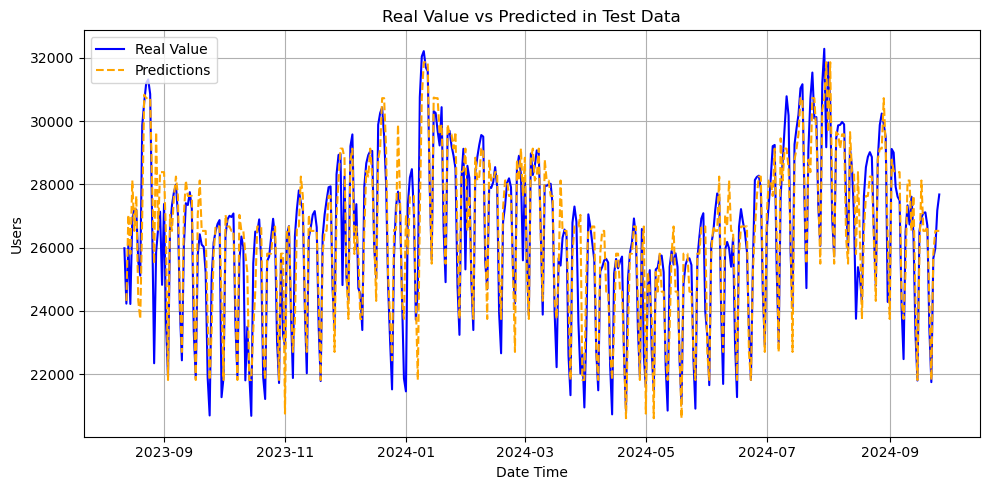

In [28]:
predictions = train[0]

plt.figure(figsize=(10, 5))  # Define el tamaño de la figura
plt.plot(data_test.index, data_test['demanda'], label="Real Value", color='blue', linestyle='-') # Valores reales
plt.plot(predictions.index, predictions['pred'], label="Predictions", color='orange', linestyle='--') # Valores predichos

# Configurar el título y las etiquetas
plt.title("Real Value vs Predicted in Test Data")
plt.xlabel("Date Time")
plt.ylabel("Users")

# Añadir leyenda
plt.legend(loc='upper left')

# Mostrar el gráfico
plt.grid()  # Añadir cuadrícula para mejor visualización
plt.tight_layout()  # Ajustar el layout
plt.show()
